## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packag

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [24]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
        out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
        model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    
    return model

In [25]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [29]:
"""
# 載入 Callbacks，撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks
"""
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def __init__(self, val_data=(x_test, y_test)):
        self.validation_data = val_data
    
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            try:
                if i not in self.params['metrics']:
                    self.params['metrics'].append(i)
            except:
                self.params['metrics'] = i

    def on_epoch_end(self, epoch, logs={}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = y_pred.argmax(axis = 1)
        val_f1sc = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        confuse = multilabel_confusion_matrix(y_true, y_pred)
        print (confuse)

        num_classes = confuse.shape[0]
        print ("numclasses: ", num_classes)

        val_tp = val_tn = 0
        for i in range(num_classes):
            val_tp += confuse[i,0,0]    
            val_tn += confuse[i,1,1]

        val_tp /= num_classes
        val_tn /= num_classes

        logs["val_tp"] = val_tp
        logs["val_tn"] = val_tn
        logs["val_f1sc"]= val_f1sc
        
rec_tptn = Record_tp_tn()

In [30]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 1s 28us/step - loss: 1.1655 - acc: 0.5984 - val_loss: 1.4674 - val_acc: 0.4850
[[[8539  461]
  [ 419  581]]

 [[8555  445]
  [ 391  609]]

 [[8257  743]
  [ 603  397]]

 [[8474  526]
  [ 736  264]]

 [[8590  410]
  [ 653  347]]

 [[8480  520]
  [ 632  368]]

 [[8208  792]
  [ 353  647]]

 [[8587  413]
  [ 467  533]]

 [[8616  384]
  [ 406  594]]

 [[8544  456]
  [ 490  510]]]
numclasses:  10
Epoch 17/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.1429 - acc: 0.6075 - val_loss: 1.4645 - val_acc: 0.4847
[[[8488  512]
  [ 408  592]]

 [[8557  443]
  [ 392  608]]

 [[8568  432]
  [ 691  309]]

 [[8430  570]
  [ 733  267]]

 [[8534  466]
  [ 616  384]]

 [[8192  808]
  [ 544  456]]

 [[8403  597]
  [ 418  582]]

 [[8529  471]
  [ 467  533]]

 [[8544  456]
  [ 369  631]]

 [[8602  398]
  [ 515  485]]]
numclasses:  10
Epoch 18/25
50000/50000 [==============================] - 1s 27us/step - loss: 1.1203 - acc: 0.6173 - v

Duplicate key in file 'C:\\Users\\MCUT\\anaconda3\\envs\\class\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc' line #250.


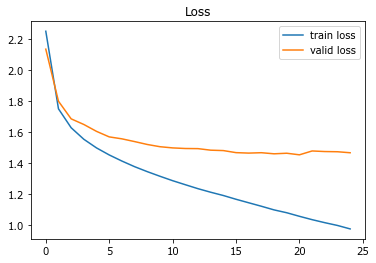

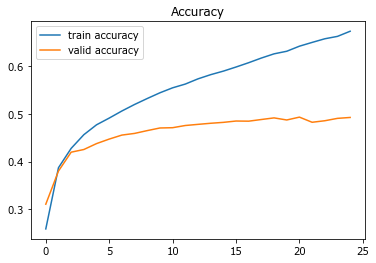

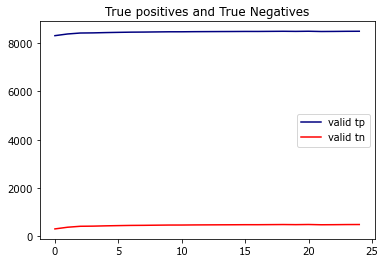

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
